In [1]:
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import numpy as np

In [20]:
def input_image(img_dir):
#     true_value = img_dir.split['.'][0] 
    print(img_dir)
    
    car_image = imread(img_dir, as_grey=True)
    gray_car_image = car_image * 255
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(gray_car_image, cmap="gray")
    threshold_value = threshold_otsu(gray_car_image)
    binary_car_image = gray_car_image > threshold_value
    
    # this gets all the connected regions and groups them together
    label_image = measure.label(binary_car_image)

    # regionprops creates a list of properties of all the labelled regions
    for region in regionprops(label_image):
        if region.area < 50:
            #if the region is so small then it's likely not a license plate
            continue

        # the bounding box coordinates
        minRow, minCol, maxRow, maxCol = region.bbox
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)

    # this gets all the connected regions and groups them together
    label_image = measure.label(binary_car_image)

    # getting the maximum width, height and minimum width and height that a license plate can be
    plate_dimensions = (0.05*label_image.shape[0], 0.3*label_image.shape[0], 0.1*label_image.shape[1], 0.4*label_image.shape[1])
    min_height, max_height, min_width, max_width = plate_dimensions
    plate_objects_cordinates = []
    plate_like_objects = []

    plate_like_objects.append(binary_car_image[:,:])

    # regionprops creates a list of properties of all the labelled regions
    for region in regionprops(label_image):
        if region.area < 50:
            #if the region is so small then it's likely not a license plate
            continue

        # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox
        region_height = max_row - min_row
        region_width = max_col - min_col
        # ensuring that the region identified satisfies the condition of a typical license plate
        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            plate_like_objects.append(binary_car_image[min_row:max_row,
                                      min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,
                                                  max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
#             print(rectBorder)

    characters = []
    column_list = []
    
    for each_plate in plate_like_objects:
        license_plate = np.invert(each_plate)

        labelled_plate = measure.label(license_plate)

        fig, ax1 = plt.subplots(1)
        ax1.imshow(license_plate, cmap="gray")

        character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
        min_height, max_height, min_width, max_width = character_dimensions

        characters = []
        counter=0
        column_list = []
        for regions in regionprops(labelled_plate):
            y0, x0, y1, x1 = regions.bbox
            region_height = y1 - y0
            region_width = x1 - x0

            if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
                roi = license_plate[y0:y1, x0:x1]

                # draw a red bordered rectangle over the character.
                rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                               linewidth=2, fill=False)
                ax1.add_patch(rect_border)

                # resize the characters to 20X20 and then append each character into the characters list
                resized_char = resize(roi, (44, 90),mode='edge')
                resized_char = resized_char < threshold_otsu(resized_char)
                characters.append(resized_char)
                # this is just to keep track of the arrangement of the characters
                column_list.append(x0)
                counter += 1
        if counter >= 3:
            break
    
    return characters, column_list

In [21]:
# load the model
current_dir = os.getcwd()
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

C:\Users\rockin\Svm\plate\test_plate\กฌ7252.png
True text: กฌ7252
Predict text: กฌ7252


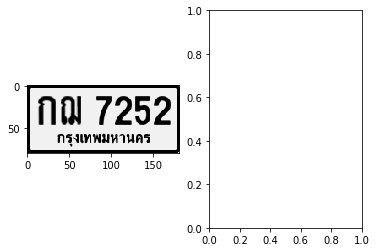

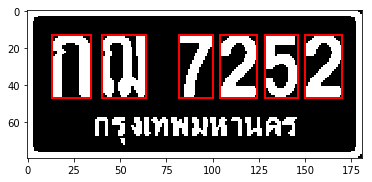

In [25]:
test_data_filename = os.listdir(os.getcwd()+'\\plate\\test_plate')

text_score = 0
char_score = 0
total_data = len(test_data_filename)
file = test_data_filename[14]

# # for file in test_data_filename:
# # test_data_path = os.getcwd() + '\\plate\\test_plate\\' + file
test_data_path = os.getcwd() + '\\plate\\test_plate\\' + file

true_string = file.split('.')[0]
characters, column_list = input_image(test_data_path)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

# print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

# print(plate_string)

column_list_copy = column_list[:]
# #     print(column_list)
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

# print(rightplate_string) 

print("True text: " + true_string)
print("Predict text: " + rightplate_string)

# if rightplate_string == true_string:
#     text_score += 1

# for x, y in zip(true_string, rightplate_string):
#     if x == y:
#         char_score += 1 / len(true_string)
# text_score = (text_score/total_data) * 100
# char_score = (char_score/total_data) * 100

# print("Text score: " + str(text_score))
# print("Char score: " + str(char_score))
    

In [79]:
len("hello")

5